In [1]:
import torch 
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import numpy as np
from random import seed,randint
import sys
sys.path.append('/proj/nobackup/hpc2nstor2024-028/zhychen/bin/software/ltr_checker')
from sequence_utils import genome_dict
from model import fasta2one_hot
import subprocess
from time import sleep
from sklearn import preprocessing
import matplotlib.pyplot as plt
from torchsummary import summary

/proj/nobackup/hpc2nstor2024-021/zhychen/miniconda3/envs/ltr_checker/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'sklearn'

In [2]:
class DETECT(torch.nn.Module):
    def __init__(self):
        super(DETECT,self).__init__()
        self.conv_unit = torch.nn.Sequential(
            torch.nn.Conv2d(1,32,kernel_size=(5,20),stride=(1,1),bias=True),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(1,10),stride=(1,10)),
            torch.nn.Conv2d(32,64,kernel_size=(1,20),stride=(1,1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(1,15),stride=(1,15)),
            torch.nn.Conv2d(64,128,kernel_size=(1,35),stride=(1,1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(1,15),stride=(1,15))
        )

        self.fc_unit = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(2432,1000),
            # torch.nn.Linear(2432,1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000,500),
            torch.nn.ReLU(),
            torch.nn.Linear(500,2),
            torch.nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.conv_unit(x)
        x = self.fc_unit(x)
        return x

In [3]:
def data_transformation(data):
    data = data.astype(int)
    data_label = np.zeros(len(data),dtype=np.float64)
    return data,data_label

def Tensor_dataset(X,Y):
    X = torch.tensor(X,dtype=torch.float32)
    Y = torch.tensor(Y,dtype=torch.float32)
    dataset = data_utils.TensorDataset(X,Y)
    dataloader = data_utils.DataLoader(dataset,batch_size=64,shuffle=False)
    return dataloader


In [4]:
def predict(dataloader,model):
    result = []
    for i, (images,labels) in enumerate(dataloader):
        images = torch.unsqueeze(images,dim=1)
        # labels = torch.unsqueeze(labels,dim=1)
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        # loss = loss_cn(outputs,labels.long())
        # _,Pred = outputs.max(1)
        # outputs = model(i)
        _,pred = outputs.max(1)
        result.append(pred)

        new_result = []
    for tensor_reuult in result:
        new_result.append(tensor_reuult.cpu().numpy().tolist())
    new_result = sum(new_result,[])
    return new_result

In [5]:
def pcolormesh_dataset(dataset):
    pcolormesh_dataset = []
    for data in dataset:
        # data = data.detach().numpy()
        data = data.tolist()
        data = data[0]
        new_dataset = []
        for i in data:
            # new_dataset = []
            i = [i]
            # print(i)
            new_dataset.append(i)
        new_dataset = np.array(new_dataset)
        pcolormesh_data = preprocessing.MaxAbsScaler().fit_transform(new_dataset)
        pcolormesh_data = pcolormesh_data.tolist()
        pcolormesh_data = list(np.ravel(pcolormesh_data))
        pcolormesh_dataset.append(pcolormesh_data)

    return pcolormesh_dataset

In [6]:
model = DETECT()
model = model.cpu()
state_dict = torch.load('/proj/nobackup/hpc2nstor2024-021/zhychen/ltr_checker/dataset/result/detect_epoch_200.pth', map_location='cpu')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
genome = genome_dict('/home/z/zhch0003/data/genome/rice/all.chrs.con')


In [12]:
#Region contain LTR-RT
#LTR-RT chr=Chr1 coords=944164:953170 5ltr=944164:944819 3ltr=952515:953170
seq = genome['Chr1'][923667:973667]
x_test = fasta2one_hot(seq,50000)
x_test = np.int8(x_test)
x_test = torch.tensor(x_test,dtype=torch.float32)
x_test = torch.unsqueeze(x_test,dim=0)
print(x_test.shape)
res = model(x_test)
_,pred = res.max(1)
print(pred)
print(_)

torch.Size([1, 1, 5, 50000])
tensor([0])
tensor([1.], grad_fn=<MaxBackward0>)


In [18]:
#Region don't contain LTR-RT
seq = genome['Chr1'][50000:100000]
X_test = fasta2one_hot(seq,50000)
X_test = np.int8(X_test)
X_test = torch.tensor(X_test,dtype=torch.float32)
X_test = torch.unsqueeze(X_test,dim=0)
print(X_test.shape)
res = model(X_test)
_,pred = res.max(1)
print(pred)
print(_)

torch.Size([1, 1, 5, 50000])
tensor([0])
tensor([1.], grad_fn=<MaxBackward0>)


In [9]:
res

tensor([[0.9645, 0.0431]], grad_fn=<SigmoidBackward0>)

In [14]:
# LTR-RT region
mid_res = []
input = x_test
conv_unit = model.conv_unit
model.eval()

for layer in conv_unit:
    mid_res.append(input.to('cpu'))
    input = layer(input)

fc_unit = model.fc_unit

for layer in fc_unit:
    mid_res.append(input.to('cpu'))
    input = layer(input)

mid_res.append(input.to('cpu'))

In [19]:
# Non-LTR-RT region
Mid_res = []
input = X_test
conv_unit = model.conv_unit
model.eval()

for layer in conv_unit:
    Mid_res.append(input.to('cpu'))
    input = layer(input)

fc_unit = model.fc_unit

for layer in fc_unit:
    Mid_res.append(input.to('cpu'))
    input = layer(input)

Mid_res.append(input.to('cpu'))

In [114]:
print(type(mid_res))
print(type(mid_res[0]) if len(mid_res) > 0 else "empty list")

<class 'list'>
<class 'torch.Tensor'>


In [20]:
mid_res_detached = [t.detach().cpu() for t in mid_res]
torch.save(mid_res_detached, 'tensor_data.pt')
Mid_res_detached = [t.detach().cpu() for t in Mid_res]
torch.save(Mid_res_detached, 'non-LTR_RTtensor_data.pt')

In [27]:
Pcolormesh_dataset = []
for data in mid_res[7][0]:
    # data = mid_res[7][0]
    # data = data.cpu().detach().numpy()
    data = data.tolist()
    data = data[0]
    new_dataset = []
    for i in data:
        # new_dataset = []
        i = [i]
        # print(i)
        new_dataset.append(i)
    new_dataset = np.array(new_dataset)
    pcolormesh_data = preprocessing.MaxAbsScaler().fit_transform(new_dataset)
    if pcolormesh_data[250][0] < 0 and pcolormesh_data[100][0] > 0:
        pcolormesh_data = - pcolormesh_data
    elif pcolormesh_data[250][0] < 0 and pcolormesh_data[100][0] < 0:
        zhuo = pcolormesh_data[:180]
        you = - pcolormesh_data[180:]
        pcolormesh_data = np.vstack((zhuo,you))
        # print(pcolormesh_data)
        # print(pcolormesh_data.shape)
    # elif pcolormesh_data[250][0] < 0 and pcolormesh_data[150][0] < 0:
    else:
        pcolormesh_data = pcolormesh_data
    pcolormesh_data = pcolormesh_data.tolist()
    pcolormesh_data = list(np.ravel(pcolormesh_data))
    Pcolormesh_dataset.append(pcolormesh_data)

/scratch/ipykernel_95756/2128441495.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm=plt.cm.get_cmap('jet')


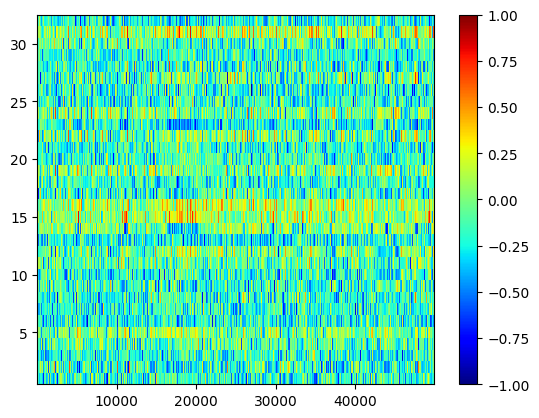

In [28]:
#Conv-1
Pcolormesh_dataset = pcolormesh_dataset(mid_res[1][0])
x=np.linspace(1,49981,49981)
y=np.linspace(1,32,32)
X,Y=np.meshgrid(x,y)
cm=plt.cm.get_cmap('jet')
plt.pcolormesh(X,Y,np.array(Pcolormesh_dataset),cmap=cm)
plt.colorbar()
plt.show()

/scratch/ipykernel_95756/3369874227.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm=plt.cm.get_cmap('jet')


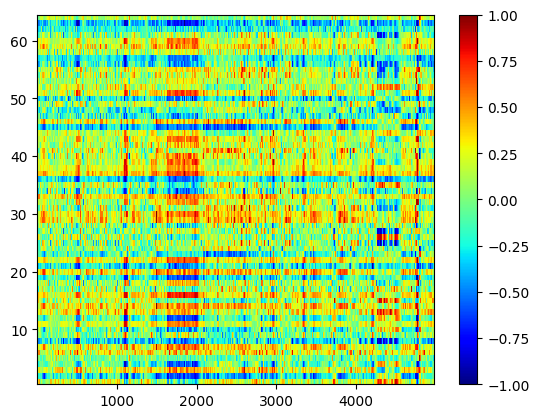

In [29]:
#Conv-2
Pcolormesh_dataset = pcolormesh_dataset(mid_res[4][0])
x=np.linspace(1,4979,4979)
y=np.linspace(1,64,64)
X,Y=np.meshgrid(x,y)
cm=plt.cm.get_cmap('jet')
plt.pcolormesh(X,Y,np.array(Pcolormesh_dataset),cmap=cm)
plt.colorbar()
plt.show()


/scratch/ipykernel_95756/1106960994.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm=plt.cm.get_cmap('jet')


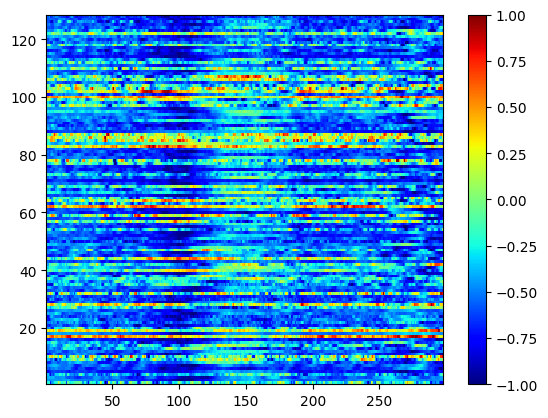

In [30]:
#Conv-3
Pcolormesh_dataset = pcolormesh_dataset(mid_res[7][0])
x=np.linspace(1,297,297)
y=np.linspace(1,128,128)
X,Y=np.meshgrid(x,y)
cm=plt.cm.get_cmap('jet')
plt.pcolormesh(X,Y,np.array(Pcolormesh_dataset),cmap=cm)
plt.colorbar()
plt.show()

In [14]:
#Conv-3 development
Pcolormesh_dataset = []
for data in mid_res[7][0]:
    # data = mid_res[7][0]
    # data = data.cpu().detach().numpy()
    data = data.tolist()
    data = data[0]
    new_dataset = []
    for i in data:
        # new_dataset = []
        i = [i]
        # print(i)
        new_dataset.append(i)
    new_dataset = np.array(new_dataset)
    pcolormesh_data = preprocessing.MaxAbsScaler().fit_transform(new_dataset)
    if pcolormesh_data[250][0] < 0 and pcolormesh_data[100][0] > 0:
        pcolormesh_data = - pcolormesh_data
    elif pcolormesh_data[250][0] < 0 and pcolormesh_data[100][0] < 0:
        zhuo = pcolormesh_data[:180]
        you = - pcolormesh_data[180:]
        pcolormesh_data = np.vstack((zhuo,you))
        # print(pcolormesh_data)
        # print(pcolormesh_data.shape)
    # elif pcolormesh_data[250][0] < 0 and pcolormesh_data[150][0] < 0:
    else:
        pcolormesh_data = pcolormesh_data
    pcolormesh_data = pcolormesh_data.tolist()
    pcolormesh_data = list(np.ravel(pcolormesh_data))
    Pcolormesh_dataset.append(pcolormesh_data)

/scratch/ipykernel_989754/3561936200.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm=plt.cm.get_cmap('jet')


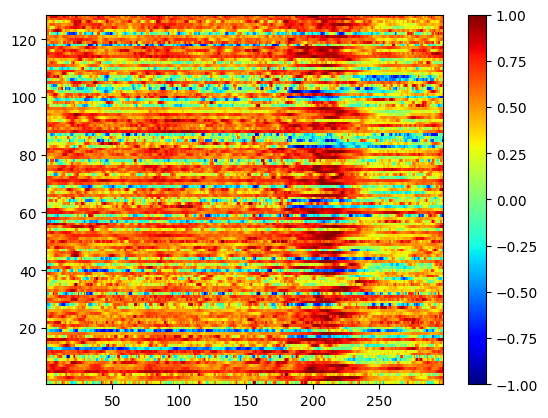

In [102]:
Pcolormesh_dataset = []
for data in mid_res[7][0]:
    # data = mid_res[7][0]
    # data = data.cpu().detach().numpy()
    data = data.tolist()
    data = data[0]
    new_dataset = []
    for i in data:
        # new_dataset = []
        i = [i]
        # print(i)
        new_dataset.append(i)
    new_dataset = np.array(new_dataset)
    pcolormesh_data = preprocessing.MaxAbsScaler().fit_transform(new_dataset)
    # if pcolormesh_data[203][0] < 0 and pcolormesh_data[100][0] > 0:
    if pcolormesh_data[203][0] < 0:
        pcolormesh_data = - pcolormesh_data
    # elif pcolormesh_data[250][0] < 0 and pcolormesh_data[100][0] < 0:
    elif pcolormesh_data[203][0] > 0:
        zhuo = pcolormesh_data[:180]
        you = - pcolormesh_data[180:]
        pcolormesh_data = np.vstack((zhuo,you))
        # print(pcolormesh_data)
        # print(pcolormesh_data.shape)
    # elif pcolormesh_data[250][0] < 0 and pcolormesh_data[150][0] < 0:
    else:
        pcolormesh_data = pcolormesh_data
    pcolormesh_data = pcolormesh_data.tolist()
    pcolormesh_data = list(np.ravel(pcolormesh_data))
    Pcolormesh_dataset.append(pcolormesh_data)
x=np.linspace(1,297,297)
y=np.linspace(1,128,128)
X,Y=np.meshgrid(x,y)
cm=plt.cm.get_cmap('jet')
plt.pcolormesh(X,Y,np.array(Pcolormesh_dataset),cmap=cm)
plt.colorbar()
plt.show()

In [97]:
pcolormesh_data[250][0]

np.float64(-0.458628084212327)

In [92]:
mid_res[7][0].shape

torch.Size([128, 1, 297])

In [91]:
len(mid_res[7][0])

128